In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
ROOT_DIR = ''
#os.chdir('Mask_RCNN')


In [2]:

import glob
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import warnings 
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [3]:
# DATA_DIR = 'Mask_RCNN/data'
# train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
# test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [4]:


def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 



In [5]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  ## match target distribution
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 200

config = DetectorConfig()


In [6]:

# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

In [7]:

import warnings 
warnings.filterwarnings("ignore")


class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
model_path = "weights/mask_rcnn_pneumonia_0010.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  weights/mask_rcnn_pneumonia_0010.h5


In [8]:
import colorsys
hsv = [(i / 2, 1, 1.0) for i in range(2)]

COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
random.shuffle(COLORS)

In [9]:
COLORS

[(1.0, 0.0, 0.0), (0.0, 1.0, 1.0)]

In [10]:
#test_image_fps = get_dicom_fps(test_dicom_dir)
def predict(ORIG_SIZE = 1024): 
    #image_id = random.choice(test_image_fps)
    image_id = 'uploads/c121b434-a3cf-415b-9229-0ec10a66d6be.dcm'
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]

    results = model.detect([resized_image])
    r = results[0]
    
    color = (1.0, 0.0, 0.0)
    for bbox in r['rois']: 
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        
        x_ = x1
        y_ = y1-20
        x_1 = x1
        y_1= y1-40
        cv2.putText(image, 'Pneumonia', (x_, y_), cv2.FONT_HERSHEY_SIMPLEX,
        0.6, color, 5)
        
#         cv2.putText(image, r['scores'][0], (x_1, y_1), cv2.FONT_HERSHEY_SIMPLEX,
#         0.6, color, 5)

        print(r['scores'][1])
        width = x2 - x1 
        height = y2 - y1 
        #plt.figure() 
    #plt.imshow(image, cmap=plt.cm.gist_gray)
    
    file_name = '{}_detected.png'.format(image_id.split(".dicom")[0])

    return results[0]['scores'], file_name, image
    #return results
#visualize()

In [41]:
def predict(ORIG_SIZE = 1024): 
    #image_id = random.choice(test_image_fps)
    image_id = 'uploads/c121b434-a3cf-415b-9229-0ec10a66d6be.dcm'
    ds = pydicom.read_file(image_id)
    
    # original image 
    image = ds.pixel_array
    
    # assume square image 
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]

    results = model.detect([resized_image])
    r = results[0]
    font = cv2.FONT_HERSHEY_SIMPLEX 
    
    # org 
    org = (50, 50) 
    
    # fontScale 
    fontScale = 1
    
  
    color = (51,255, 51)
    mask_color = (102,178,255)
    # Line thickness of 2 px 
    thickness = 2
    for i in range(len(r['rois'])):
        print(image.shape)
        mask = r["masks"][:, :, i]

        image = visualize.apply_mask(resized_image, mask, color =mask_color, alpha=0.003)
    
    
    image = cv2.resize(image, (1024,1024), cv2.INTER_LINEAR)
    print(image.shape)

    for i in range(len(r['rois'])): 

        x1 = int(r['rois'][i][1] * resize_factor)
        y1 = int(r['rois'][i][0] * resize_factor)
        x2 = int(r['rois'][i][3] * resize_factor)
        y2 = int(r['rois'][i][2]  * resize_factor)
        
        mask = r["masks"][:, :, i]
        

        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        
        x_ = x1
        y_ = y1-40
        x_1 = x1
        y_1= y1-80
        cv2.putText(image, 'Detected Pneumonia', (x_, y_), cv2.FONT_HERSHEY_SIMPLEX,
        fontScale, color, thickness, cv2.LINE_AA)
        
        cv2.putText(image, 'confidence = {:.2f}'.format(r['scores'][i]), (x_1, y_1), cv2.FONT_HERSHEY_SIMPLEX,
        fontScale, color, thickness, cv2.LINE_AA)

        print(r['scores'][i])
        width = x2 - x1 
        height = y2 - y1 
    #plt.imshow(image, cmap=plt.cm.gist_gray)
    
    file_name = '{}_detected.png'.format(image_id.split(".dicom")[0])

    return results[0]['scores'], file_name, image
    #return results
#visualize()

In [42]:
def make_preds():
    test_predictions, file_name, image =  predict(ORIG_SIZE = 1024)
    status = 'detected.'
    if test_predictions[0] > 0.4:

        status = 'detected.'
        print(f'Pneumonia positive detected with confidence of: {test_predictions[0]}')
        cv2.imwrite(file_name, image)
        plt.figure() 
        plt.imshow(image, cmap=plt.cm.gist_gray)
        plt.axis('off')
    else:
        status = 'not detected.'
        print('Pneumonia not detected')
        cv2.imwrite(file_name, image)
        plt.figure() 
        plt.imshow(image, cmap=plt.cm.gist_gray)
        plt.axis('off')
    return 

(1024, 1024, 3)
(256, 256, 3)
(1024, 1024, 3)
0.9427576
0.9048179
Pneumonia positive detected with confidence of: 0.9427576065063477


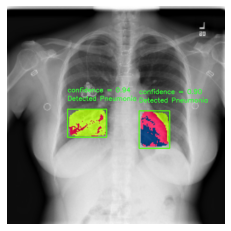

In [43]:
make_preds()

In [ ]:
l=predict()

In [30]:
l[0]

{'rois': array([[121,  71, 154, 117],
        [123, 155, 167, 191]], dtype=int32),
 'class_ids': array([1, 1], dtype=int32),
 'scores': array([0.9427576, 0.9048179], dtype=float32),
 'masks': array([[[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        ...,
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [False, False],
         [False, False]],
 
        [[False, False],
         [False, False],
         [False, False],
         ...,
         [False, False],
         [Fa